# conditioning parameters on experimentally accessible particle properties
Tim Tyree<br>
9.29.2021

In [1]:
# %matplotlib notebook
from lib.my_initialization import *
import random,scipy
from scipy import stats

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda

from lib.viewer.gener_q_vs_w_for_df import *

from lib.my_initialization import *
from lib import *
%load_ext autoreload
%autoreload 2

In [2]:
import dask_cudf,cudf,cupy as cp

In [3]:
import cupyx

In [4]:
import cucim

In [5]:
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)

fk_pbc lr_pbc fk_ncbc lr_ncbc


# compute a function that maps r,kappa,varkappa,D to M,m

In [6]:
#didn't work for LinearNDInterpolator
# from numba import cuda
# @cuda.jit
# def multiply(in_col, out_col, multiplier):
#     i = cuda.grid(1)
#     if i < in_col.size: # boundary guard
#         out_col[i] = in_col[i] * multiplier
# interp.__defaults__=None
# cinterp=cuda.jit(interp)
# def foo(x):
#     return x
# foo.__defaults__
# blockspergrid=16
# threadsperblock=16
# cYhat=cinterp[blockspergrid, threadsperblock](X.get())

In [7]:
#list of files to include from the map from particle properties to powerlaw fits
data_folder='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/'
input_fn_lst=[
    'run_15_all_powerlaw_fits.csv',
    'run_16_all_powerlaw_fits.csv',
    'run_17_all_powerlaw_fits.csv',
    'run_18_all_powerlaw_fits.csv',
]

#load the data
os.chdir(data_folder)
ddf=dask_cudf.read_csv(input_fn_lst,npartitions=4)
df=cudf.DataFrame(ddf.compute())
df.dropna(inplace=True)
print(f"there were {df.shape[0]} rows found in the list of csv files")

there were 45687 rows found in the list of csv files


In [8]:
##################### 
#compute the map from input_cols=['r','kappa','D','varkappa'] to output_col='m'
##################### ~1min run time for fitting, ~4min for testing
#define constant parameters
reflect=0
force_code=2
set_second=0
neighbor=0
no_attraction=0
no_repulsion=0
# kappa=100
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
dg=df[query]

# #define parameters to be varied
# # input_cols=['r','kappa']#TODO(if rmse is still zero here...): simply repeat with varkappa,D fixed
# # input_cols=['r','D','varkappa']#,x0
# input_cols=['r','kappa','D','varkappa']#,x0
# output_col='m'
# #inputs:dg,input_cols,output_col
# #output: fitted model

# Xall=dg[input_cols].values 
# yall=dg[output_col].values
# X=Xall.get()
# y=yall.get()
# m = len(y) # number of training examples
# print(f'number of training examples is {m:d}')

# interp = LinearNDInterpolator(X, y)
# # interp = CloughTocher2DInterpolator(X, y)
# yhat = interp(X)
# boona=np.isnan(yhat)
# rmse=np.sqrt(np.mean((yhat[~boona]-y[~boona])**2))
# print(f"the rmse of simple interpolation is {rmse:.4f}")
# print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

__Results__ 

#DONE: was the rmse high because I was using multiple slices with reflect=0 and 1? Yes.
- linear nd interpolation was consistent to 1e-5 for fill_value=True versus False.
- linear nd interpolation was consistent to 1e-16 for one output column at a time versus all 4 output columns
- linear nd interpolation trained on D=0.2 data had an rmse_M = 0.0339837, which is much smaller than the unconstrained rmse_M = 0.7284194
    - __Corollary__, if I have the brute force grid search already present, then it makes sense to use it in interpolation
 
#DONE: confirmed slicing the dataframe fixed everything...
- interpolating from d=4 to d=1 gave rmse_m=0.001 when constraining to periodic boundary conditions and the other procedural parameters to a single category of function, which was ~7X better than forgetting about that...

In [140]:
# boo=df['D']==0.1
#extract features X=(r,kappa,varkappa,D) to labels Y=(M,m) as cupy arrays
X_col_lst=['r','kappa','varkappa','D']
# X_col_lst=['varkappa','D','r','kappa']
Y_col_lst=['M','m', 'Delta_M','Delta_m']
# Y_col_lst="M"#['M']#,'m', 'Delta_M','Delta_m']
# Xall=dg.loc[boo,X_col_lst].values
# Yall=dg.loc[boo,Y_col_lst].values
Xall=dg[X_col_lst].values
Yall=dg[Y_col_lst].values

In [272]:
#compute the linear interpolating function from (r,kappa,varkappa,D) to (M,m)
#TODO: find a cupy implementation of LinearNDInterpolator
X=Xall.get()
Y=Yall.get()

# xgrid = np.mgrid[-1:1:50j, -1:1:50j]
# interp = scipy.interpolate.RBFInterpolator(X, Y, 
#                                            neighbors=15,
# #                                            smoothing=1.,kernel='linear')#(xflat){'thin_plate_spline', 'cubic', 'quintic', 'linear'}.
# #                                            smoothing=0.001,kernel='linear')#(xflat){'thin_plate_spline', 'cubic', 'quintic', 'linear'}.
#                                            smoothing=0.001,kernel='gaussian',epsilon=0.1)#(xflat){'thin_plate_spline', 'cubic', 'quintic', 'linear'}.

# #DONE: test if the imperfect interpolation is the result of having multiple target values
interp=LinearNDInterpolator(points=X, values=Y, rescale=False)
# # interp=LinearNDInterpolator(points=X, values=Y)#, fill_value=np.nan, rescale=True)
# # interp=LinearNDInterpolator(points=X.get(), values=Y.get(), fill_value=np.nan, rescale=True)

In [ ]:
# from inspect import signature

# signature(interp).parameters#, follow_wrapped=True)
Y.shape

In [232]:
Yhat=interp(X)
print('the inputs can be evaluated!')

se=(cp.array(Yhat)-Yall)**2
boona=cp.isnan(se[:,0])
# Y[boona,0],cp.array(Yhat)[boona,0]  #was one row only when I looked
mse=cp.mean(se[~boona],axis=0)
rmse=cp.sqrt(mse)
# interp=LinearNDInterpolator(points=X.get(), values=Y.get())#, fill_value=np.nan, rescale=True)
print(f"the rmse of linear interpolation is\n\t{rmse}\nfor\t{Y_col_lst}")

# # # DONE: test rmse of the linear RBFInterpolator with 15 neighbors
# the inputs can be evaluated!
# the rmse of linear interpolation is
# 	[0.0933669  0.00072217 0.0453468  0.00012483]
# for	['M', 'm', 'Delta_M', 'Delta_m']

# # DONE: test rmse of the linear RBFInterpolator with 300 neighbors
# the inputs can be evaluated!
# the rmse of linear interpolation is
# 	[0.08795691 0.00070626 0.04275492 0.00012456]
# for	['M', 'm', 'Delta_M', 'Delta_m']

# # # DONE: test rmse of the linear RBFInterpolator with 3 neighbors
# the inputs can be evaluated!
# the rmse of linear interpolation is
# 	[1.47973001e-01 9.47869258e-04 6.10703994e-02 1.28425583e-04]
# for	['M', 'm', 'Delta_M', 'Delta_m']

# DONE(if rmse is still too big here...): simply repeat with varkappa,D fixed
# the rmse of simple interpolation is 0.0010
# #for rescale=False,
# the rmse of linear interpolation is
# 	[0.11341626 0.00096018 0.05280392 0.00017267]
# for	['M', 'm', 'Delta_M', 'Delta_m']

# #for rescale=True,
# the rmse of linear interpolation is
# 	[0.11341453 0.00096017 0.05280311 0.00017267]
# for	['M', 'm', 'Delta_M', 'Delta_m']

the inputs can be evaluated!
the rmse of linear interpolation is
	[0.11341453 0.00096017 0.05280311 0.00017267]
for	['M', 'm', 'Delta_M', 'Delta_m']


In [273]:
#TODO: fix D and varkappa to reasonable values for the FK,LR models
#FK
D=0.365#238 #+- 0.004171  
varkappa=9.524#+-1.517 #direct "measurement"
varkappa=1.9 #eyeballed from a versus r*kappa**p for p = 1 or 0.5
#LR
# D=0.586#055 #+- 0.087553  #didn't yield the desired level sets
# varkappa=96.614#+-20.658
# varkappa=19 #eyeballed from a versus r*kappa**p for p = 1 or 0.5
# varkappa=9.5
# D=1#didn't help
# varkappa=1.

In [274]:
#

In [275]:
#make a uniform grid over two axes at r,kappa conditioned on varkappa,D
x1col=0
x2col=1
num_samples=100

xi=[]
x1=X[:,x1col]
xi.append(np.linspace(np.min(x1), np.max(x1),num_samples))
x2=X[:,x2col]
xi.append(np.linspace(np.min(x2), np.max(x2),num_samples))
XI=np.meshgrid(*xi)
# print(len(XI))
x1_values=XI[0]
x2_values=XI[1]

#holding varkappa and D fixed, interpolate from r,kappa to Yhat
# np.array(list(zip(XI))).shape
gridshape=x1_values.shape
X_values=np.array(list(zip((x1_values.flatten(),x2_values.flatten(),varkappa+0.*x1_values.flatten(),D+0.*x2_values.flatten()))))[:,0,:].T#[:,fixed_row,:].T


#compute the interpolated values of y on this 2D grid for each 
# interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
Y_values = interp(X_values).reshape(gridshape[0],gridshape[1],len(Y_col_lst))
Y_values.shape,X_values.shape,x1_values.shape
# print(np.max(x1_values))

# return x1_values.shape,x2_values.shape,Y_values

((100, 100, 4), (10000, 4), (100, 100))

__LinearNDFit is the problem for why I can't get contours__ The input m values include 1.6~1.8, while interpolated values apparently do not.

TODO: interpolate using radial basis functions

In [ ]:
plt.hist(Y_values[:,1].flatten(),density=True)
plt.hist(Y[:,1].flatten(),density=True)
print(f"are we seeing smaller exponents 1.6~1.8?")
print((Y[:,1].flatten().min(),Y[:,1].flatten().max()))
print((Y_values[:,1].flatten().min(),Y_values[:,1].flatten().max()))
plt.ylabel(r'$\nu$')
plt.xlim([0,10])
plt.show()

In [267]:
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
#TODO: compute the level set contours
def compute_powerlaw_levelsets(x1_values,x2_values,Y_values,model_name='fk_pbc',
                              navg=50,m_col=1,M_col=0,
                              **kwargs):
    num_points=x1_values.shape[0]*x1_values.shape[1]
    X_values=np.stack((x1_values,x2_values)).reshape((num_points,2))
    output_col='m'
    level=wjr[model_name][output_col];print(level)
    y=Y_values[...,m_col].flatten()
    contour_m_values=comp_longest_level_set_and_smooth(X_values,y,level,navg=navg)

    output_col='M'
    level=wjr[model_name][output_col];print(level)
    y=Y_values[...,M_col].flatten()
    contour_M_values=comp_longest_level_set_and_smooth(X_values,y,level,navg=navg)
    return contour_m_values,contour_M_values


# - TODO: find any a:=varkappa value that supports power law fits for both full models
# - TODO: find an upper and lower bound on the a:=varkappa values that support power law fits for both full models
try:
    contour_m_values,contour_M_values = compute_powerlaw_levelsets(x1_values,x2_values,Y_values,model_name='fk_pbc',
                              navg=50,m_col=1,M_col=0)
    print(f"---: fenton-karma model might be supported")
except AssertionError as e:
    print(f"{e}: fenton-karma model not supported anywhere")
    
try:
    contour_m_values,contour_M_values = compute_powerlaw_levelsets(x1_values,x2_values,Y_values,model_name='lr_pbc',
                              navg=50,m_col=1,M_col=0)
    print(f"---: luo-rudy model might be supported")
except AssertionError as e:
    print(f"{e}: luo-rudy     model not supported anywhere")

1.8772341309722325
: fenton-karma model not supported anywhere
1.6375562704001745
: luo-rudy     model not supported anywhere


/home/timothytyree/Documents/GitHub/bgmc/python/lib/lib_care/routines/interp_texture_from_scatter_data.py:37: GradientEstimationWarning: Gradient estimation did not converge, the results may be inaccurate
  interp = CloughTocher2DInterpolator(X, y,**kwargs)


In [268]:
# #m
# y_values=Y_values[...,1]
# #M
# y_values=Y_values[...,0]
# print((x1_values.shape,x2_values.shape,y_values.shape))

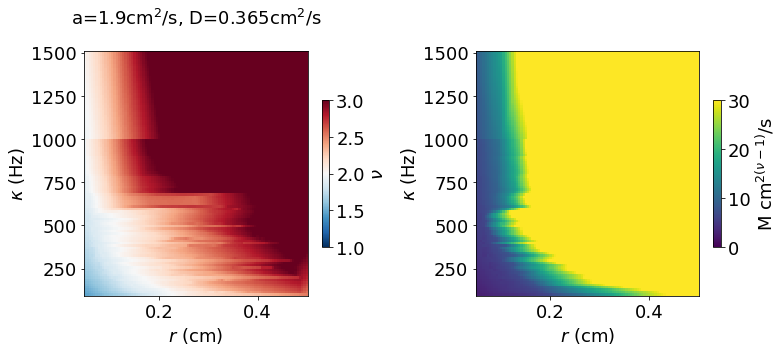

In [276]:
#plot the interpolated m (left) and the interpolated M (right) for each pixel.
#visualize r versus kappa conditioned on varkappa and D
x1lim=[np.min(x1_values),np.max(x1_values)]
x2lim=[np.min(x2_values),np.max(x2_values)]
fontsize=18
xlabel=r'$r$ (cm)'
ylabel=r'$\kappa$ (Hz)'
cmap = mpl.cm.cool

#columnal kwargs
vmin_lst=[1,0]
vmax_lst=[3,30]
output_col_lst=[1,0]#['m','M']
#kwargs by row
fig, axs = plt.subplots(ncols=2, figsize=(11,5))
cmaps = ['RdBu_r', 'viridis']
title_lst=[
    f'a={varkappa}'+r'cm$^2$/s'+f', D={D}'+r'cm$^2$/s'+f'\n',
    ''#f'M={M}'+r'cm$^{2(\nu-1)}$/s, $\nu$'+f'={m}\n'
]
clabel_lst=[r'$\nu$',r'M cm$^{2(\nu-1)}$/s']
nsamples=1000
for col in range(len(output_col_lst)):
#     #extract target output value to fit to
#     output_col=output_col_lst[col]
#     yall=dg[output_col].values
# #     for row in range(2):
# #       #  restrict to fixed reaction range
# #         r=r_lst[row]
# #         title=title_foo(r)#f'r = {r:.1f} cm'
#         boo=Xall[:,0]==r
#         X=Xall[boo,1:3].copy()  #make the x,y axis the 2nd and 3rd columns of X
#         y=yall[boo].copy()
#         #TODO: compute the m,M fits
#         #TODO: compute the interpolated values of y on this 2D grid
#         interp = LinearNDInterpolator(X, y)
    output_col=output_col_lst[col]
    y_values=Y_values[...,output_col]
    
    ax = axs[col]
    vmin=vmin_lst[col]
    vmax=vmax_lst[col]

#         vmin=np.quantile(y_values.flatten(),0.25)
#         vmax=np.quantile(y_values.flatten(),0.75)
    pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col],shading='auto')

#TODO: interpolate in 2D and plot the levelsets
#         interp_2d = CloughTocher2DInterpolator(X, y)

    
#         ax.set_xlim(x1lim)
#         ax.set_ylim(x2lim)
    title=title_lst[col]
    ax.set_title(title,fontsize=fontsize)
    format_plot(ax, xlabel, ylabel, fontsize)#, use_loglog=False
#     print(np.max(x1_values))
#     fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
    cbar=fig.colorbar(pcm, ax=axs[col],shrink=0.6)#,label=output_col)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(clabel_lst[col], fontsize=fontsize)    
plt.tight_layout()
plt.show()

In [277]:
# num_points=x1_values.shape[0]*x1_values.shape[1]
# X=np.stack((x1_values,x2_values)).reshape((num_points,2))
# X.shape
model_name='fk_pbc'
print(model_name)
print_dict(wjr[model_name])
print('')
model_name='lr_pbc'
print(model_name)
print_dict(wjr[model_name])

fk_pbc
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

lr_pbc
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


__Looking at the a versus r*kappa**p plot of the star values of run 18...__
We would expect a_FK~1.9

And a_LR~9.5

Which has a_LR/a_F~9.5/1.9=5

__Looking at the apparent a from the full models in care...__
We would expect a_FK~9.524

And a_LR~96.614

Which has a_LR/a_F~2

In [70]:
D=0.365#238 #+- 0.004171  
varkappa=9.524#+-1.517 #direct "measurement"
varkappa=1.9 #eyeballed from a versus r*kappa**p for p = 1 or 0.5
#LR
D=0.586#055 #+- 0.087553  #didn't yield the desired level sets
# varkappa=96.614#+-20.658
# varkappa=19 #eyeballed from a versus r*kappa**p for p = 1 or 0.5
19/9.524

1.9949601007979842

__The percent disagreement for either model__

In [71]:
96.614/19

5.084947368421052

In [72]:
9.524/1.9

5.012631578947368

... __Result__ if my estimate for a were 5X smaller, then I would get an intersection point?

# fix a,D andthen compute a function that maps r,kappa to M,m

In [6]:
#didn't work for LinearNDInterpolator
# from numba import cuda
# @cuda.jit
# def multiply(in_col, out_col, multiplier):
#     i = cuda.grid(1)
#     if i < in_col.size: # boundary guard
#         out_col[i] = in_col[i] * multiplier
# interp.__defaults__=None
# cinterp=cuda.jit(interp)
# def foo(x):
#     return x
# foo.__defaults__
# blockspergrid=16
# threadsperblock=16
# cYhat=cinterp[blockspergrid, threadsperblock](X.get())

In [278]:
#list of files to include from the map from particle properties to powerlaw fits
data_folder='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/'
input_fn_lst=[
#     'run_15_all_powerlaw_fits.csv',
#     'run_16_all_powerlaw_fits.csv',
    'run_17_all_powerlaw_fits.csv',
#     'run_18_all_powerlaw_fits.csv',
]

#load the data
os.chdir(data_folder)
ddf=dask_cudf.read_csv(input_fn_lst,npartitions=4)
df=cudf.DataFrame(ddf.compute())
df.dropna(inplace=True)
print(f"there were {df.shape[0]} rows found in the list of csv files")

there were 17988 rows found in the list of csv files


In [292]:
df.head()

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,D,varkappa,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction
0,1.641119,0.007645,54.528312,1.648415,0.999509,0.665144,18.994667,lr_pbc,0.1,1.0,...,0.7,60,0,10,2,0,0,0,0,0
1,2.280272,0.012753,23.200022,0.781969,0.999292,0.344470,2.243069,lr_pbc,0.1,1.0,...,0.5,3,0,10,2,0,0,0,0,0
2,1.465498,0.010825,30.107889,1.081580,0.998766,0.402209,7.710124,lr_pbc,0.1,1.0,...,0.1,50,0,10,2,0,0,0,0,0
3,1.389798,0.009320,26.111256,0.820105,0.998983,0.324505,5.865428,lr_pbc,0.1,1.0,...,0.1,100,0,10,2,0,0,0,0,0
4,1.953750,0.011357,27.907967,0.898390,0.999235,0.341752,4.859846,lr_pbc,0.1,1.0,...,0.5,8,0,10,2,0,0,0,0,0


In [281]:
D_values=np.array(sorted(set(df.D.values.get())))#cm^2/s
varkappa_values=np.array(sorted(set(df.varkappa.values.get())))#1/s
print(D_values)
print(varkappa_values)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[  1   2   3   4   5   6   7   8   9  10  15  20  25  30  35  40  45  50
  60  70  80  90 100 110]


In [326]:
#TODO: fix D and varkappa to reasonable values for the FK,LR models
#FK
D=0.365#238 #+- 0.004171  
varkappa=9.524#+-1.517 #direct "measurement"
varkappa=1.9 #eyeballed from a versus r*kappa**p for p = 1 or 0.5
#LR
# D=0.586#055 #+- 0.087553  #didn't yield the desired level sets
# varkappa=96.614#+-20.658
# varkappa=19 #eyeballed from a versus r*kappa**p for p = 1 or 0.5
# varkappa=9.5
# D=1#didn't help
# varkappa=1.


#~FK
D=0.3
varkappa=2
# #~LR
# D=0.6
# varkappa=10

In [402]:
##################### 
#compute the map from input_cols=['r','kappa','D','varkappa'] to output_col='m'
##################### ~1min run time for fitting, ~4min for testing
#define constant parameters
reflect=0
force_code=2
set_second=0
neighbor=0
no_attraction=0
no_repulsion=0
# kappa=100
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=cp.isclose(df.D,D)
query&=df.L==L
# query&=df.varkappa==varkappa#cp.isclose(df.D,D)
# query&=df.x0==x0
dg=df[query]
query_template=query.copy()
dg.head()
# #define parameters to be varied
# # input_cols=['r','kappa']#TODO(if rmse is still zero here...): simply repeat with varkappa,D fixed
# # input_cols=['r','D','varkappa']#,x0
# input_cols=['r','kappa','D','varkappa']#,x0
# output_col='m'
# #inputs:dg,input_cols,output_col
# #output: fitted model

# Xall=dg[input_cols].values 
# yall=dg[output_col].values
# X=Xall.get()
# y=yall.get()
# m = len(y) # number of training examples
# print(f'number of training examples is {m:d}')

# interp = LinearNDInterpolator(X, y)
# # interp = CloughTocher2DInterpolator(X, y)
# yhat = interp(X)
# boona=np.isnan(yhat)
# rmse=np.sqrt(np.mean((yhat[~boona]-y[~boona])**2))
# print(f"the rmse of simple interpolation is {rmse:.4f}")
# print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,D,varkappa,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction
0,1.641119,0.007645,54.528312,1.648415,0.999509,0.665144,18.994667,lr_pbc,0.1,1.0,...,0.7,60,0,10,2,0,0,0,0,0
1,2.280272,0.012753,23.200022,0.781969,0.999292,0.344470,2.243069,lr_pbc,0.1,1.0,...,0.5,3,0,10,2,0,0,0,0,0
2,1.465498,0.010825,30.107889,1.081580,0.998766,0.402209,7.710124,lr_pbc,0.1,1.0,...,0.1,50,0,10,2,0,0,0,0,0
3,1.389798,0.009320,26.111256,0.820105,0.998983,0.324505,5.865428,lr_pbc,0.1,1.0,...,0.1,100,0,10,2,0,0,0,0,0
4,1.953750,0.011357,27.907967,0.898390,0.999235,0.341752,4.859846,lr_pbc,0.1,1.0,...,0.5,8,0,10,2,0,0,0,0,0


__Results__ 

#DONE: was the rmse high because I was using multiple slices with reflect=0 and 1? Yes.
- linear nd interpolation was consistent to 1e-5 for fill_value=True versus False.
- linear nd interpolation was consistent to 1e-16 for one output column at a time versus all 4 output columns
- linear nd interpolation trained on D=0.2 data had an rmse_M = 0.0339837, which is much smaller than the unconstrained rmse_M = 0.7284194
    - __Corollary__, if I have the brute force grid search already present, then it makes sense to use it in interpolation
 
#DONE: confirmed slicing the dataframe fixed everything...
- interpolating from d=4 to d=1 gave rmse_m=0.001 when constraining to periodic boundary conditions and the other procedural parameters to a single category of function, which was ~7X better than forgetting about that...

In [403]:
# boo=df['D']==0.1
#extract features X=(r,kappa,varkappa,D) to labels Y=(M,m) as cupy arrays
X_col_lst=['r','kappa']
# X_col_lst=['varkappa','D','r','kappa']
Y_col_lst=['M','m', 'Delta_M','Delta_m']
# Y_col_lst="M"#['M']#,'m', 'Delta_M','Delta_m']
# Xall=dg.loc[boo,X_col_lst].values
# Yall=dg.loc[boo,Y_col_lst].values
Xall=dg[X_col_lst].values
Yall=dg[Y_col_lst].values

In [404]:
#compute the linear interpolating function from (r,kappa,varkappa,D) to (M,m)
#TODO: find a cupy implementation of LinearNDInterpolator
X=Xall.get()
Y=Yall.get()

# xgrid = np.mgrid[-1:1:50j, -1:1:50j]
# interp = scipy.interpolate.RBFInterpolator(X, Y, 
#                                            neighbors=15,
# #                                            smoothing=1.,kernel='linear')#(xflat){'thin_plate_spline', 'cubic', 'quintic', 'linear'}.
# #                                            smoothing=0.001,kernel='linear')#(xflat){'thin_plate_spline', 'cubic', 'quintic', 'linear'}.
#                                            smoothing=0.001,kernel='gaussian',epsilon=0.1)#(xflat){'thin_plate_spline', 'cubic', 'quintic', 'linear'}.

# # #DONE: test if the imperfect interpolation is the result of having multiple target values
# interp=LinearNDInterpolator(points=X, values=Y, rescale=False)
# # # interp=LinearNDInterpolator(points=X, values=Y)#, fill_value=np.nan, rescale=True)
# # # interp=LinearNDInterpolator(points=X.get(), values=Y.get(), fill_value=np.nan, rescale=True)

In [405]:
from lib.lib_care.routines.interp_texture_from_scatter_data import *
from lib.lib_care.measure.level_sets import *

In [406]:
# from inspect import signature

# signature(interp).parameters#, follow_wrapped=True)
X.shape,Y.shape

((17988, 2), (17988, 4))

In [407]:
# Yhat=interp(X)
# print('the inputs can be evaluated!')

# se=(cp.array(Yhat)-Yall)**2
# boona=cp.isnan(se[:,0])
# # Y[boona,0],cp.array(Yhat)[boona,0]  #was one row only when I looked
# mse=cp.mean(se[~boona],axis=0)
# rmse=cp.sqrt(mse)
# # interp=LinearNDInterpolator(points=X.get(), values=Y.get())#, fill_value=np.nan, rescale=True)
# print(f"the rmse of linear interpolation is\n\t{rmse}\nfor\t{Y_col_lst}")

# # # # DONE: test rmse of the linear RBFInterpolator with 15 neighbors
# # the inputs can be evaluated!
# # the rmse of linear interpolation is
# # 	[0.0933669  0.00072217 0.0453468  0.00012483]
# # for	['M', 'm', 'Delta_M', 'Delta_m']

# # # DONE: test rmse of the linear RBFInterpolator with 300 neighbors
# # the inputs can be evaluated!
# # the rmse of linear interpolation is
# # 	[0.08795691 0.00070626 0.04275492 0.00012456]
# # for	['M', 'm', 'Delta_M', 'Delta_m']

# # # # DONE: test rmse of the linear RBFInterpolator with 3 neighbors
# # the inputs can be evaluated!
# # the rmse of linear interpolation is
# # 	[1.47973001e-01 9.47869258e-04 6.10703994e-02 1.28425583e-04]
# # for	['M', 'm', 'Delta_M', 'Delta_m']

# # DONE(if rmse is still too big here...): simply repeat with varkappa,D fixed
# # the rmse of simple interpolation is 0.0010
# # #for rescale=False,
# # the rmse of linear interpolation is
# # 	[0.11341626 0.00096018 0.05280392 0.00017267]
# # for	['M', 'm', 'Delta_M', 'Delta_m']

# # #for rescale=True,
# # the rmse of linear interpolation is
# # 	[0.11341453 0.00096017 0.05280311 0.00017267]
# # for	['M', 'm', 'Delta_M', 'Delta_m']

In [408]:
# X.shape,X_values.shape

In [409]:
# #make a uniform grid over two axes at r,kappa conditioned on varkappa,D
# x1col=0
# x2col=1
# num_samples=100

# xi=[]
# x1=X[:,x1col]
# xi.append(np.linspace(np.min(x1), np.max(x1),num_samples))
# x2=X[:,x2col]
# xi.append(np.linspace(np.min(x2), np.max(x2),num_samples))
# XI=np.meshgrid(*xi)
# # print(len(XI))
# x1_values=XI[0]
# x2_values=XI[1]

# #holding varkappa and D fixed, interpolate from r,kappa to Yhat
# # np.array(list(zip(XI))).shape
# gridshape=x1_values.shape
# X_values=np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T#[:,fixed_row,:].T
# print(X_values.shape)

# #compute the interpolated values of y on this 2D grid for each 
# # interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, Y)
# Y_values = interp(X_values).reshape(gridshape[0],gridshape[1],len(Y_col_lst))
# Y_values.shape,X_values.shape,x1_values.shape
# # print(np.max(x1_values))

# # return x1_values.shape,x2_values.shape,Y_values

__LinearNDFit is the problem for why I can't get contours__ The input m values include 1.6~1.8, while interpolated values apparently do not.

TODO: interpolate using radial basis functions

In [410]:
y=Y[:,0]
#interpolate textures from scatter plots
x1_values,x2_values,y_values = interp_txt_from_scatter(X,y,nsamples=1000,mode ='spline')
compute_powerlaw_levelsets

model_name='fk_pbc'
navg=50
output_col='m'
level=wjr[model_name][output_col]
y=Y[...,1]
contour_m_values=comp_longest_level_set_and_smooth(X,y,level,navg=navg)

output_col='M'
level=wjr[model_name][output_col]
y=Y[...,0]
contour_M_values=comp_longest_level_set_and_smooth(X,y,level,navg=navg)



x1star_values, x2star_values=compute_intersections(contour_m_values,contour_M_values)
x1star_values, x2star_values

(array([], dtype=float64), array([], dtype=float64))

In [411]:
# plt.hist(Y_values[:,1].flatten(),density=True)
# plt.hist(Y[:,1].flatten(),density=True)
# print(f"are we seeing smaller exponents 1.6~1.8?")
# print((Y[:,1].flatten().min(),Y[:,1].flatten().max()))
# print((Y_values[:,1].flatten().min(),Y_values[:,1].flatten().max()))
# plt.ylabel(r'$\nu$')
# plt.xlim([0,10])
# plt.show()

In [412]:
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
#TODO: compute the level set contours
def compute_powerlaw_levelsets(X,Y,model_name='fk_pbc',
                              navg=50,m_col=1,M_col=0,
                              **kwargs):
#     num_points=x1_values.shape[0]*x1_values.shape[1]
#     X_values=np.stack((x1_values,x2_values)).reshape((num_points,2))
    output_col='m'
    level=wjr[model_name][output_col]#;print(level)
#     y=y_m#Y_values[...,m_col].flatten()
    y=Y[...,m_col]
    contour_m_values=comp_longest_level_set_and_smooth(X,y,level,navg=navg)

    output_col='M'
    level=wjr[model_name][output_col]#;print(level)
    y=Y[...,M_col]
#     y=y_M#Y_values[...,M_col].flatten()
    contour_M_values=comp_longest_level_set_and_smooth(X,y,level,navg=navg)
    return contour_m_values,contour_M_values


# - TODO: find any a:=varkappa value that supports power law fits for both full models
# - TODO: find an upper and lower bound on the a:=varkappa values that support power law fits for both full models
try:
    contour_m_values,contour_M_values = compute_powerlaw_levelsets(X,Y,model_name='fk_pbc')
#                               navg=50,m_col=1,M_col=0)
    print(f"---: fenton-karma model might be supported")
except AssertionError as e:
    print(f"{e}: fenton-karma model not supported anywhere")
    
try:
    contour_m_values,contour_M_values = compute_powerlaw_levelsets(X,Y,model_name='lr_pbc')
#                               navg=50,m_col=1,M_col=0)
    print(f"---: luo-rudy model might be supported")
except AssertionError as e:
    print(f"{e}: luo-rudy     model not supported anywhere")

---: fenton-karma model might be supported
---: luo-rudy model might be supported


In [413]:

contour_m_values,contour_M_values = compute_powerlaw_levelsets(X,Y,model_name='fk_pbc')
x1star_values, x2star_values=compute_intersections(contour_m_values,contour_M_values)
print((x1star_values.size))

contour_m_values,contour_M_values = compute_powerlaw_levelsets(X,Y,model_name='lr_pbc')
x1star_values, x2star_values=compute_intersections(contour_m_values,contour_M_values)
print((x1star_values.size))

0
0


In [415]:
# #plot the interpolated m (left) and the interpolated M (right) for each pixel.
# #visualize r versus kappa conditioned on varkappa and D
# x1lim=[np.min(x1_values),np.max(x1_values)]
# x2lim=[np.min(x2_values),np.max(x2_values)]
# fontsize=18
# xlabel=r'$r$ (cm)'
# ylabel=r'$\kappa$ (Hz)'
# cmap = mpl.cm.cool

# #columnal kwargs
# vmin_lst=[1,0]
# vmax_lst=[3,30]
# output_col_lst=[1,0]#['m','M']
# #kwargs by row
# fig, axs = plt.subplots(ncols=2, figsize=(11,5))
# cmaps = ['RdBu_r', 'viridis']
# title_lst=[
#     f'a={varkappa}'+r'cm$^2$/s'+f', D={D}'+r'cm$^2$/s'+f'\n',
#     ''#f'M={M}'+r'cm$^{2(\nu-1)}$/s, $\nu$'+f'={m}\n'
# ]
# clabel_lst=[r'$\nu$',r'M cm$^{2(\nu-1)}$/s']
# nsamples=1000
# for col in range(len(output_col_lst)):
#     output_col=output_col_lst[col]
#     y=Y[output_col]
#     x1_values,x2_values,y_values = interp_txt_from_scatter(X,y,nsamples=1000,mode ='spline')
    
#     contour_m_values_FK,contour_M_values_FK= compute_powerlaw_levelsets(X,Y,model_name='fk_pbc')
#     contour_m_values_LR,contour_M_values_LR= compute_powerlaw_levelsets(X,Y,model_name='lr_pbc')
    
#     ax = axs[col]
#     vmin=vmin_lst[col]
#     vmax=vmax_lst[col]

# #         vmin=np.quantile(y_values.flatten(),0.25)
# #         vmax=np.quantile(y_values.flatten(),0.75)
#     pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col],shading='auto')


    
# #         ax.set_xlim(x1lim)
# #         ax.set_ylim(x2lim)
#     title=title_lst[col]
#     ax.set_title(title,fontsize=fontsize)
#     format_plot(ax, xlabel, ylabel, fontsize)#, use_loglog=False
# #     print(np.max(x1_values))
# #     fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[col],shrink=0.6)#,label=output_col)
#     cbar.ax.tick_params(labelsize=fontsize)
#     cbar.set_label(clabel_lst[col], fontsize=fontsize)    
# plt.tight_layout()
# plt.show()

In [418]:
X.shape,

((17988, 2), (4,))

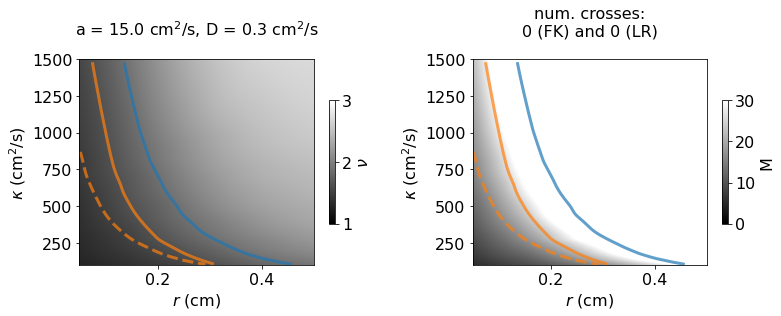

In [461]:
D=0.3
varkappa=15
#visualize the level sets
#compute the data for background image 
query = cp.isclose(df['D'],D)
query&= (df['varkappa']==varkappa)
query&= query_template

#TODO: make plotting the background colored image functional
#visualize a versus r
x1lim=[0.05,0.5]
x2lim=[100,1500]
# x2lim=[0,50]
fontsize=16
x1label=r'$r$ (cm)'
x2label=r'$\kappa$ (cm$^2$/s)'

title_foo=lambda varkappa,D:f'a = {varkappa:.1f} '+r'cm$^2$/s'+f', D = {D:.1f} '+r'cm$^2$/s'+f'\n'
title=title_foo(varkappa,D)
lw=3
alpha=0.7
cmap = 'gray'#'bone'  #'RdBu_r'#'Greys'# 
use_cbar=True
show_cbar =True
use_loglog=False

kwargs={}

X=df.loc[query,['r','kappa']].values.get()
Y=df.loc[query,['M','m']].values.get()
contour_m_values_FK,contour_M_values_FK= compute_powerlaw_levelsets(X,Y,model_name='fk_pbc')
contour_m_values_LR,contour_M_values_LR= compute_powerlaw_levelsets(X,Y,model_name='lr_pbc')

figsize=(11,4.5)#(6,4.5)#(16,6)#(16,14)
fig,axs=plt.subplots(ncols=2, figsize=figsize)

#DONE: plot fig. A contours for m
ax=axs[0]
output_col='m'
vmin=1
vmax=3

y=df.loc[query,output_col].values.get()
x1_values,x2_values,y_values=interp_txt_from_scatter(X,y,nsamples=1000)
# clabel=output_col
clabel=r'$\nu$'

PlotInterpolatedBackground(fig,ax,x1_values,x2_values,y_values,vmin,vmax,clabel,cmap,fontsize=fontsize,show_cbar=show_cbar,**kwargs)
FormatAxes(ax,x1lim=x1lim,x2lim=x2lim,x1label=x1label,x2label=x2label,title=title,fontsize=fontsize,use_loglog=use_loglog,**kwargs)      

#DONE: plot the level sets and color them for the full models
ax.plot(contour_m_values_FK[:,0],contour_m_values_FK[:,1],'-',lw=lw,alpha=alpha,c='C0',**kwargs)
ax.plot(contour_m_values_LR[:,0],contour_m_values_LR[:,1],'-',lw=lw,alpha=alpha,c='C1',**kwargs)
#DONE: plot the level sets and color them for the full models
ax.plot(contour_M_values_FK[:,0],contour_M_values_FK[:,1],'--',lw=lw,alpha=alpha,c='C0',**kwargs)
ax.plot(contour_M_values_LR[:,0],contour_M_values_LR[:,1],'--',lw=lw,alpha=alpha,c='C1',**kwargs)



#DONE: plot fig. B contours for M
ax=axs[1]
output_col='M'
vmin=0
vmax=30
y=df.loc[query,output_col].values.get()
x1_values,x2_values,y_values=interp_txt_from_scatter(X,y,nsamples=1000)
clabel=output_col

x1star_values, x2star_values=compute_intersections(contour_m_values_FK,contour_M_values_FK)
num_intersections_FK=x1star_values.size

x1star_values, x2star_values=compute_intersections(contour_m_values_LR,contour_M_values_LR)
num_intersections_LR=x1star_values.size
title2=f"num. crosses:\n{num_intersections_FK} (FK) and {num_intersections_LR} (LR)\n"

PlotInterpolatedBackground(fig,ax,x1_values,x2_values,y_values,vmin,vmax,clabel,cmap,fontsize=fontsize,show_cbar=show_cbar,**kwargs)
FormatAxes(ax,x1lim=x1lim,x2lim=x2lim,x1label=x1label,x2label=x2label,title=title2,fontsize=fontsize,use_loglog=use_loglog,**kwargs)      

#DONE: plot the level sets and color them for the full models
ax.plot(contour_m_values_FK[:,0],contour_m_values_FK[:,1],'-',lw=lw,alpha=alpha,c='C0',**kwargs)
ax.plot(contour_m_values_LR[:,0],contour_m_values_LR[:,1],'-',lw=lw,alpha=alpha,c='C1',**kwargs)

#DONE: plot the level sets and color them for the full models
ax.plot(contour_M_values_FK[:,0],contour_M_values_FK[:,1],'--',lw=lw,alpha=alpha,c='C0',**kwargs)
ax.plot(contour_M_values_LR[:,0],contour_M_values_LR[:,1],'--',lw=lw,alpha=alpha,c='C1',**kwargs)

plt.tight_layout()
plt.show()

In [395]:
#TODO: iterate over all a,D values and print the number of self-consistent points found